In [47]:
import pandas as pd
data_path = "/data/lujd/neoag_data/"
raw_df = pd.read_csv(data_path+"main_task/mutation_1position.csv", index_col=0)
raw_df

,wild_type,mut_type,HLA
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01
2,HTQGLSPGCY,HTQGLSPDCY,HLA-A*01:01
3,LPPTLNPIVY,LSPTLNPIVY,HLA-A*01:01
4,ISGHRSVSWY,ISGHRSVFWY,HLA-A*01:01
...,...,...,...
149,DANPFLQSV,DANSFLQSV,HLA-B*51:01
150,TRSSGSHLVF,TRSSGSHFVF,HLA-C*07:01
151,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02
152,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01


In [60]:
hla_seq_dict = pd.read_csv(
    data_path+"main_task/HLA_sequence_dict_ABCEG.csv",
    index_col=0
    ).set_index(["HLA_name"])["clip"].to_dict()
our_hla_list = hla_seq_dict.keys()
df = raw_df[raw_df["HLA"].isin(our_hla_list)].reset_index(drop=True)
df

,wild_type,mut_type,HLA
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01
2,HTQGLSPGCY,HTQGLSPDCY,HLA-A*01:01
3,LPPTLNPIVY,LSPTLNPIVY,HLA-A*01:01
4,ISGHRSVSWY,ISGHRSVFWY,HLA-A*01:01
...,...,...,...
140,DANPFLQSV,DANSFLQSV,HLA-B*51:01
141,TRSSGSHLVF,TRSSGSHFVF,HLA-C*07:01
142,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02
143,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01


In [61]:
def diff(x, y):
    cnt = 0
    for i in range(len(x)):
        if x[i] != y[i]:
            return i+1

df['mut_pos'] = df.apply(lambda x: diff(x['wild_type'], x['mut_type']), axis=1)
df

,wild_type,mut_type,HLA,mut_pos
0,PFDTRQMLFY,PSDTRQMLFY,HLA-A*01:01,2
1,LTDDRLFTCH,LTDDRLFTCY,HLA-A*01:01,10
2,HTQGLSPGCY,HTQGLSPDCY,HLA-A*01:01,8
3,LPPTLNPIVY,LSPTLNPIVY,HLA-A*01:01,2
4,ISGHRSVSWY,ISGHRSVFWY,HLA-A*01:01,8
...,...,...,...,...
140,DANPFLQSV,DANSFLQSV,HLA-B*51:01,4
141,TRSSGSHLVF,TRSSGSHFVF,HLA-C*07:01,8
142,RPRAIRRPLAL,RPHAIRRPLAL,HLA-B*07:02,3
143,GIVEGLMTTV,GIVEGLITTV,HLA-A*02:01,7


In [62]:
hlas = df.HLA.to_list()
wild_peps = df.wild_type.to_list()
mut_peps = df.mut_type.to_list()
mut_poss = df.mut_pos.to_list()

In [64]:
mut_peps[38], wild_peps[38], mut_poss[38]

('KLYGLDWAEL', 'KPYGLDWAEL', 2)

In [40]:
import sys 
if ".." not in sys.path:
    sys.path.append("..")

import torch
from tape import TAPETokenizer, ProteinBertConfig
from model_ft import meanTAPE

# prepare model
use_cuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
model_path = "/data/lujd/neoag_model/main_task/TAPE_ft/cat_mean_2mlp/"
model_name = "main_finetune_plm_tape_B32_LR3e-05_seq_clip_fold4_ep51_221104.pkl"

print("Model preparing")
tokenizer = TAPETokenizer(vocab='iupac')
tape_config = ProteinBertConfig.from_pretrained('bert-base')
model = meanTAPE(tape_config, "2mlp").to(device)
model.load_state_dict(torch.load(model_path + model_name, map_location=device), strict = True)
print("Model preparing done")

Model preparing
Model preparing done


- raw

In [69]:
from mutation_release import get_mutated_peptides

hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=5, prob_limit=1.0,
                                                  writein_file=False, algorithm="2a")
    if given_mut in output_pep:
        is_hitten = 1
        hit_num += 1
    else:
        is_hitten = 0

    if given_pos in output_pos:
        pos_is_hitten = 1
        hit_pos_num += 1
    else:
        pos_is_hitten = 0
    print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: NFDTRQMLFY | 1 P->N | binding probability: 0.9980
source peptide: PFDTRQMLFY, mutated peptide: WFDTRQMLFY | 1 P->W | binding probability: 0.9981
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['NFDTRQMLFY', 'WFDTRQMLFY', 'FFDTRQMLFY', 'DFDTRQMLFY', 'YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
Iteration-1, mutant_pool size: 19
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCL | 10 H->L | binding probability: 0.9819
source peptide: LTDDRLFTCH, mutated peptide: LTDDRLFTCM | 10 H->M |

In [70]:
hit_num, hit_pos_num

(29, 46)

- non-binding predicted by our model

In [77]:
from mutation_release import get_mutated_peptides

neg_num = 0
hit_num, is_hitten = 0, 0
hit_pos_num, pos_is_hitten = 0, 0
for i, hla in enumerate(hlas):
    wild_pep, given_mut, given_pos = wild_peps[i], mut_peps[i], mut_poss[i]
    output_pos, output_pep = get_mutated_peptides(hla, wild_pep, tokenizer, model, device,
                                                  num_mutation=1, num_peptides=5, prob_limit=0.5,
                                                  writein_file=False, algorithm="2a")
    if len(output_pep) > 0:
        neg_num += 1
        if given_mut in output_pep:
            is_hitten = 1
            hit_num += 1
        else:
            is_hitten = 0

        if given_pos in output_pos:
            pos_is_hitten = 1
            hit_pos_num += 1
        else:
            pos_is_hitten = 0
        print(f"--- {i}\t{hla},{wild_pep}\t| output:{output_pep}, given:{given_mut}\t| {is_hitten} {pos_is_hitten}\n")

given HLA: HLA-A*01:01, given peptide: PFDTRQMLFY | binding porbability: 0.0359
Iteration-1, mutant_pool size: 19
source peptide: PFDTRQMLFY, mutated peptide: NFDTRQMLFY | 1 P->N | binding probability: 0.9980
source peptide: PFDTRQMLFY, mutated peptide: WFDTRQMLFY | 1 P->W | binding probability: 0.9981
source peptide: PFDTRQMLFY, mutated peptide: FFDTRQMLFY | 1 P->F | binding probability: 0.9991
source peptide: PFDTRQMLFY, mutated peptide: DFDTRQMLFY | 1 P->D | binding probability: 0.9995
source peptide: PFDTRQMLFY, mutated peptide: YFDTRQMLFY | 1 P->Y | binding probability: 0.9998
--- 0	HLA-A*01:01,PFDTRQMLFY	| output:['NFDTRQMLFY', 'WFDTRQMLFY', 'FFDTRQMLFY', 'DFDTRQMLFY', 'YFDTRQMLFY'], given:PSDTRQMLFY	| 0 0

given HLA: HLA-A*01:01, given peptide: LTDDRLFTCH | binding porbability: 0.7354
No need to mutate
given HLA: HLA-A*01:01, given peptide: HTQGLSPGCY | binding porbability: 0.9933
No need to mutate
given HLA: HLA-A*01:01, given peptide: LPPTLNPIVY | binding porbability: 0.9930
N

In [78]:
neg_num, hit_pos_num, hit_num

(42, 19, 16)

Plotting

([<matplotlib.axis.XTick at 0x7f5ab23ae160>,
 [Text(0, 0, 'Top1'),
  Text(1, 0, 'Top3'),
  Text(2, 0, 'Top5'),
  Text(3, 0, 'Position')])

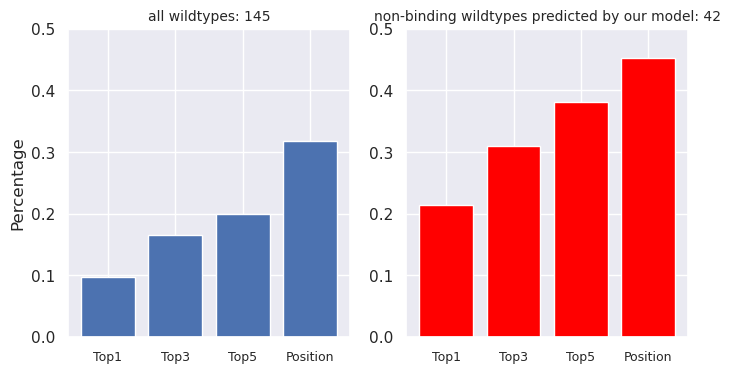

In [80]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

cell = ['Top1','Top3','Top5','Position']
index = np.arange(len(cell)) 

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121)
total1 = 145
x1 = np.asarray([14, 24, 29, 46])
plt.bar(index, x1/total1)
ax1.set_title(f"all wildtypes: {total1}", fontsize=10)
plt.ylabel("Percentage")
plt.ylim([0, 0.5])
plt.xticks(index, cell, fontsize=9)

ax2 = plt.subplot(122)
total2 = 42
x2 = np.asarray([9, 13, 16, 19])
plt.bar(index, x2/total2, color="red")
ax2.set_title(f"non-binding wildtypes predicted by our model: {total2}", fontsize=10)
plt.ylabel("Percentage")
plt.ylabel("")
plt.ylim([0, 0.5])
plt.xticks(index, cell, fontsize=9)

# fig.suptitle("Model-2 over Model-1 on HLA-Bs",fontsize=15,x=0.49,y=1.02)